# Import packages

In [1]:
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt

import OncoMarkAI as oma
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Plot setting

In [2]:
oma.pl.fig_setting()
cmap = oma.pl.cmap()

2023-11-15 18:19:42|INFO|plotting|Figure setting updated


In [3]:
## Download KIRs
# KIRs = pd.read_csv("https://static-content.springer.com/esm/art%3A10.1186%2Fs12915-022-01392-2/MediaObjects/12915_2022_1392_MOESM3_ESM.txt", sep="\t", index_col=0)
# KIRs.to_csv("KIRs_genotyping_TCGA.csv")

KIRs = pd.read_csv("KIRs_genotyping_TCGA.csv", index_col=0)

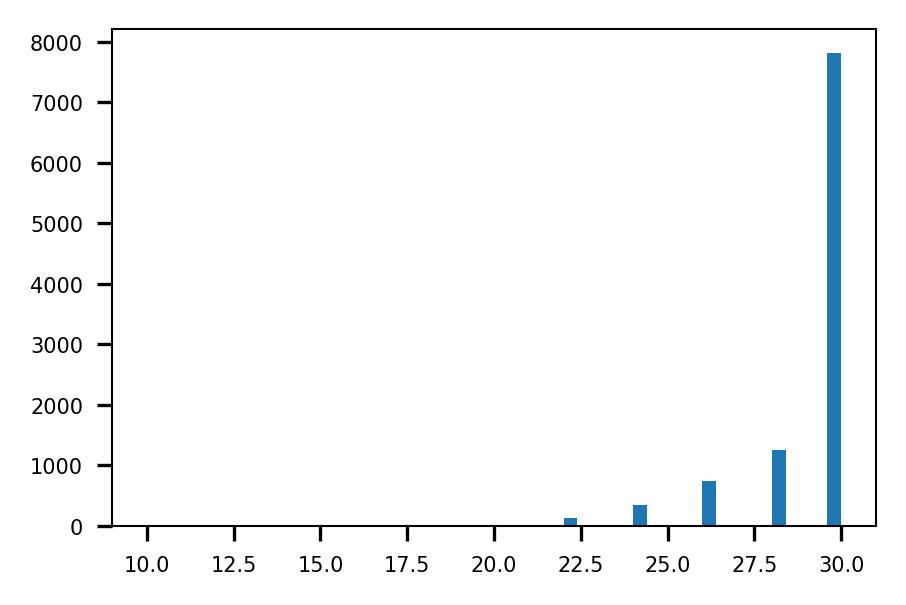

In [4]:
plt.figure(figsize=(3,2))
plt.hist(KIRs.sum(axis=1), bins=50);

In [5]:
KIR3DL2 = KIRs.loc[:, KIRs.columns.str.startswith("KIR3DL2")]

In [6]:
# KIR3DL2 = KIR3DL2.loc[:, KIR3DL2.sum(axis=0) > 200]

KIR3DL2.index = ["-".join(idx.split("-")[:3]) for idx in KIR3DL2.index]
KIR3DL2 = KIR3DL2.stack().to_frame("allele").rename_axis(["submitter_id", "KIR3DL2 allotypes"])
KIR3DL2 = KIR3DL2[KIR3DL2>0].reset_index().dropna().set_index("submitter_id")
KIR3DL2 = KIR3DL2[["KIR3DL2 allotypes"]].reset_index().drop_duplicates().set_index("submitter_id")

frac = KIR3DL2.groupby("KIR3DL2 allotypes").size().sort_values(ascending=False) / KIR3DL2.index.nunique()
frac = frac.to_frame("percentage")
frac["%"] = round(frac*100, 1)
frac["allotypes"] = frac.index.astype(str) + " (" + frac["%"].astype(str) + "%)"

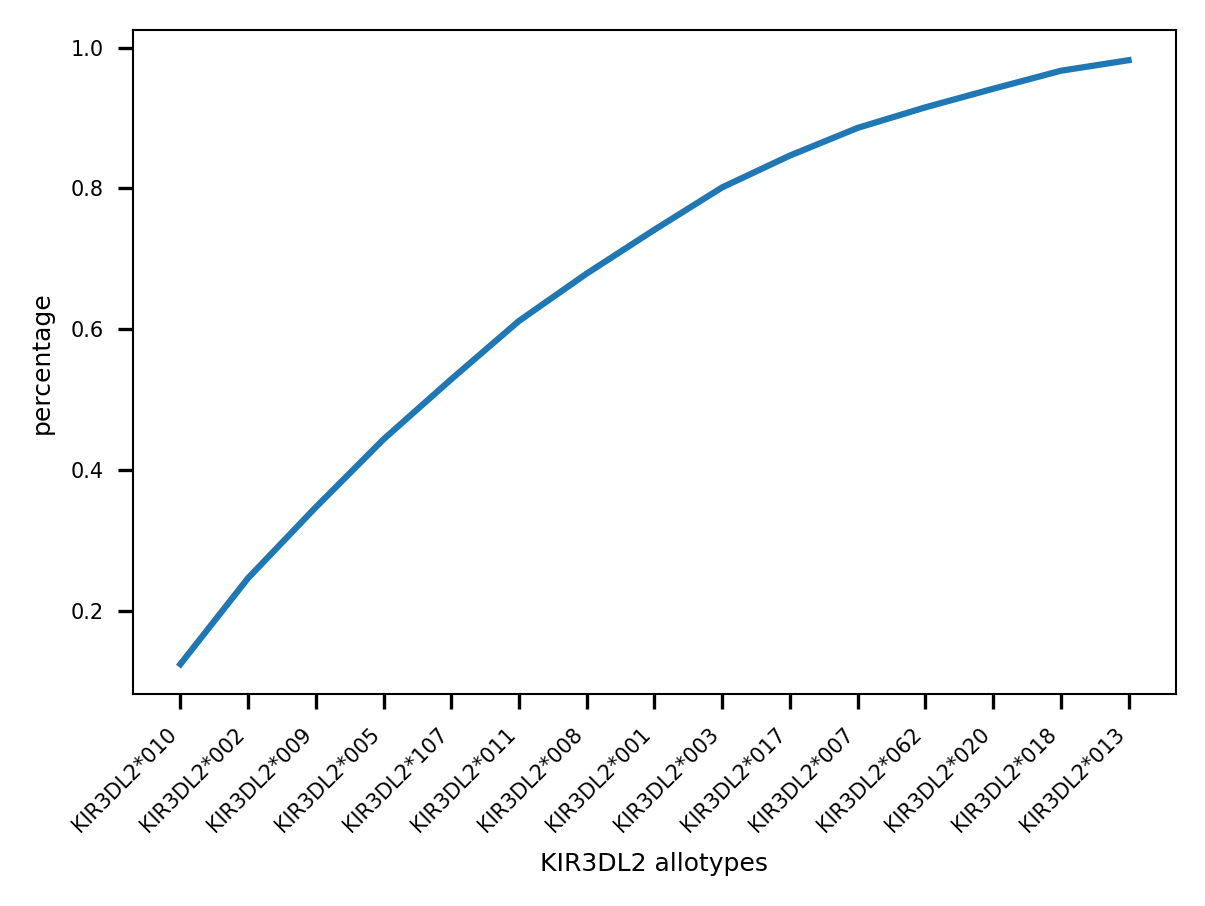

In [7]:
ax = sns.lineplot(data=frac.cumsum().head(15).reset_index(), x="KIR3DL2 allotypes", y="percentage")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

In [8]:
patient_data_TCGA_tumor = oma.data.load_tcga(filter_samples=100, sample_type="Tumor", genes=["IGSF8", "KIR3DL2"])
IGSF8_tumor = patient_data_TCGA_tumor.to_df().join(patient_data_TCGA_tumor.obs[["project_id","submitter_id", "samples.sample_type"]])
IGSF8_tumor = IGSF8_tumor[~IGSF8_tumor['project_id'].isin(['LAML', "DLBC"])].set_index("submitter_id")

2023-11-15 18:19:42|INFO|dataloader|No file path provided. Using the TCGA RNAseq file in the .datasets folder.
/Users/caibin/miniconda3/envs/general/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
2023-11-15 18:19:43|INFO|dataloader|Dropping duplicates...
2023-11-15 18:19:44|INFO|dataloader|912 patient samples are missing in the RNAseq data.
2023-11-15 18:19:44|INFO|dataloader|Take Tumor samples only.
2023-11-15 18:19:44|INFO|dataloader|Take gene expression data of ['IGSF8', 'KIR3DL2']
2023-11-15 18:19:44|INFO|dataloader|Filtering out patients with < 100 samples...


In [9]:
KIR3DL2_all_IGSF8 = KIR3DL2.join(IGSF8_tumor).dropna()
KIR3DL2_all_IGSF8 = KIR3DL2_all_IGSF8[KIR3DL2_all_IGSF8["KIR3DL2 allotypes"].isin(frac.index[:15])]
KIR3DL2_all_IGSF8["allotypes"] = KIR3DL2_all_IGSF8["KIR3DL2 allotypes"].map(frac["allotypes"])

In [10]:
from itertools import combinations
from scipy.stats import ttest_ind, f_oneway
from statsmodels.stats.multitest import multipletests

grouped = KIR3DL2_all_IGSF8.groupby(['KIR3DL2 allotypes'])
tstat_results = pd.DataFrame(index=grouped["KIR3DL2 allotypes"].count().index, columns=["tstat", "pvalue"])
for idx,row in tstat_results.iterrows():
    tstat, p_value = ttest_ind(KIR3DL2_all_IGSF8.query('`KIR3DL2 allotypes`==@idx')["IGSF8"].values, KIR3DL2_all_IGSF8.query('`KIR3DL2 allotypes`!=@idx')["IGSF8"].values)
    tstat_results.loc[idx, "tstat"] = tstat
    tstat_results.loc[idx, "pvalue"] = p_value
    
tstat_results.loc[:, "adj.pval"] = multipletests(tstat_results.loc[:, "pvalue"], method='fdr_bh', alpha=0.05)[1]

In [11]:
tstat_results

,tstat,pvalue,adj.pval
KIR3DL2 allotypes,,,
KIR3DL2*001,-1.889605,0.058847,0.294235
KIR3DL2*002,1.046039,0.295575,0.612208
KIR3DL2*003,1.309201,0.190504,0.571511
KIR3DL2*005,0.072189,0.942453,0.942453
KIR3DL2*007,2.174379,0.029706,0.222794
KIR3DL2*008,-1.042706,0.297116,0.612208
KIR3DL2*009,-0.901546,0.367325,0.612208
KIR3DL2*010,0.531929,0.59479,0.811077
KIR3DL2*011,-0.386184,0.699371,0.855597


In [12]:
tstat_results = tstat_results[tstat_results["adj.pval"] < 0.05]

In [13]:
KIR_alllotype = KIR3DL2_all_IGSF8.groupby("KIR3DL2 allotypes").count()[KIR3DL2_all_IGSF8.groupby("KIR3DL2 allotypes").count() > 100].dropna().index
HLA_A_IGSF8 = KIR3DL2_all_IGSF8[KIR3DL2_all_IGSF8["KIR3DL2 allotypes"].isin(KIR_alllotype)]
ordered_KIR_allotypes = KIR3DL2_all_IGSF8.groupby("KIR3DL2 allotypes").count().sort_values("IGSF8", ascending=False).index

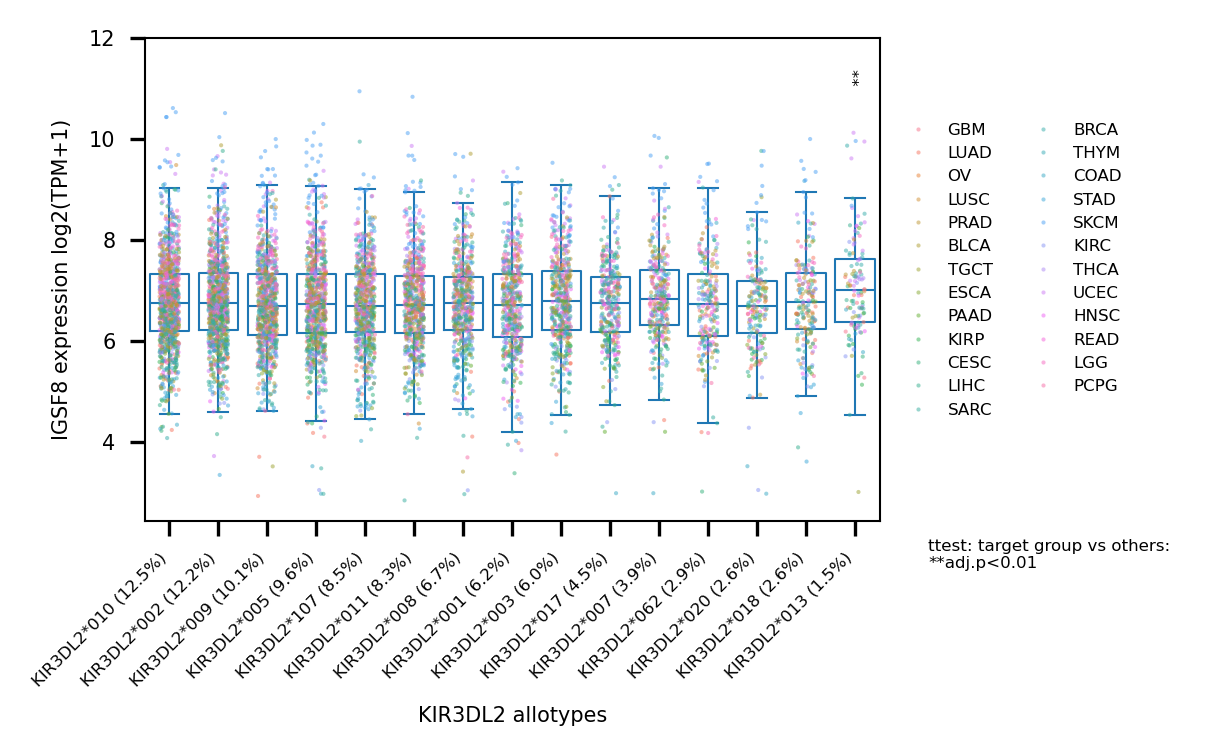

In [14]:
plt.figure(figsize=(4.,2.5))
ax = sns.boxplot(data=KIR3DL2_all_IGSF8,
                 x="allotypes",
                 order=frac["allotypes"][:15].values,
                 y="IGSF8",
                 fill=False,
                 linecolor="#137",
                 linewidth=.5,
                 showfliers=False
                 # hue=""
                )
ax = sns.stripplot(data=KIR3DL2_all_IGSF8,
                   x='allotypes',
                   order=frac["allotypes"][:15].values,
                   y='IGSF8',
                   s=1.,
                   alpha=.5,
                   jitter=.2, hue='project_id',
                  )

ax.set_xlabel("KIR3DL2 allotypes", fontsize=5)
ax.set_ylabel("IGSF8 expression log2(TPM+1)", fontsize=5)
ax.legend(loc=(1.02, .2), ncols=2, fontsize=4, frameon=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=4)

# p_value = f_oneway(*[KIR3DL2_all_IGSF8['IGSF8'][KIR3DL2_all_IGSF8['KIR3DL2 allotypes'] == b] for b in KIR3DL2_all_IGSF8['KIR3DL2 allotypes'].unique()])[1]
for idx,row in tstat_results.iterrows():
    ax.text(list(ordered_KIR_allotypes).index(idx)-.05, 11, oma.pl.pval2star(row["adj.pval"], keep_pval=False), fontsize=4, rotation=90)
ax.text(15.5, 1.5, "ttest: target group vs others: \n**adj.p<0.01", fontsize=4) #***p<0.001\\n****p<0.0001  \n*p<0.05\n
ax.set_ylim(None, 12)
plt.savefig("../figures/Reviewer3_point1_IGSF8_by_3DL2s.pdf",  bbox_inches = "tight")

# KIR3DL2 expr

In [15]:
from itertools import combinations
from scipy.stats import ttest_ind, f_oneway
from statsmodels.stats.multitest import multipletests

grouped = KIR3DL2_all_IGSF8.groupby(['KIR3DL2 allotypes'])
tstat_results = pd.DataFrame(index=grouped["KIR3DL2 allotypes"].count().index, columns=["tstat", "pvalue"])
for idx,row in tstat_results.iterrows():
    tstat, p_value = ttest_ind(KIR3DL2_all_IGSF8.query('`KIR3DL2 allotypes`==@idx')["KIR3DL2"].values, KIR3DL2_all_IGSF8.query('`KIR3DL2 allotypes`!=@idx')["KIR3DL2"].values)
    tstat_results.loc[idx, "tstat"] = tstat
    tstat_results.loc[idx, "pvalue"] = p_value
    
tstat_results.loc[:, "adj.pval"] = multipletests(tstat_results.loc[:, "pvalue"], method='fdr_bh', alpha=0.05)[1]

In [16]:
tstat_results = tstat_results[tstat_results["adj.pval"] < 0.05]

In [17]:
tstat_results

,tstat,pvalue,adj.pval
KIR3DL2 allotypes,,,
KIR3DL2*001,-4.024185,0.000058,0.000433
KIR3DL2*002,3.912669,0.000092,0.00046
KIR3DL2*008,5.49692,0.0,0.000001
KIR3DL2*010,-3.165792,0.001552,0.004657
KIR3DL2*011,-3.47338,0.000517,0.001938


In [18]:
KIR_alllotype = KIR3DL2_all_IGSF8.groupby("KIR3DL2 allotypes").count()[KIR3DL2_all_IGSF8.groupby("KIR3DL2 allotypes").count() > 100].dropna().index
HLA_A_IGSF8 = KIR3DL2_all_IGSF8[KIR3DL2_all_IGSF8["KIR3DL2 allotypes"].isin(KIR_alllotype)]
ordered_KIR_allotypes = KIR3DL2_all_IGSF8.groupby("KIR3DL2 allotypes").count().sort_values("KIR3DL2", ascending=False).index

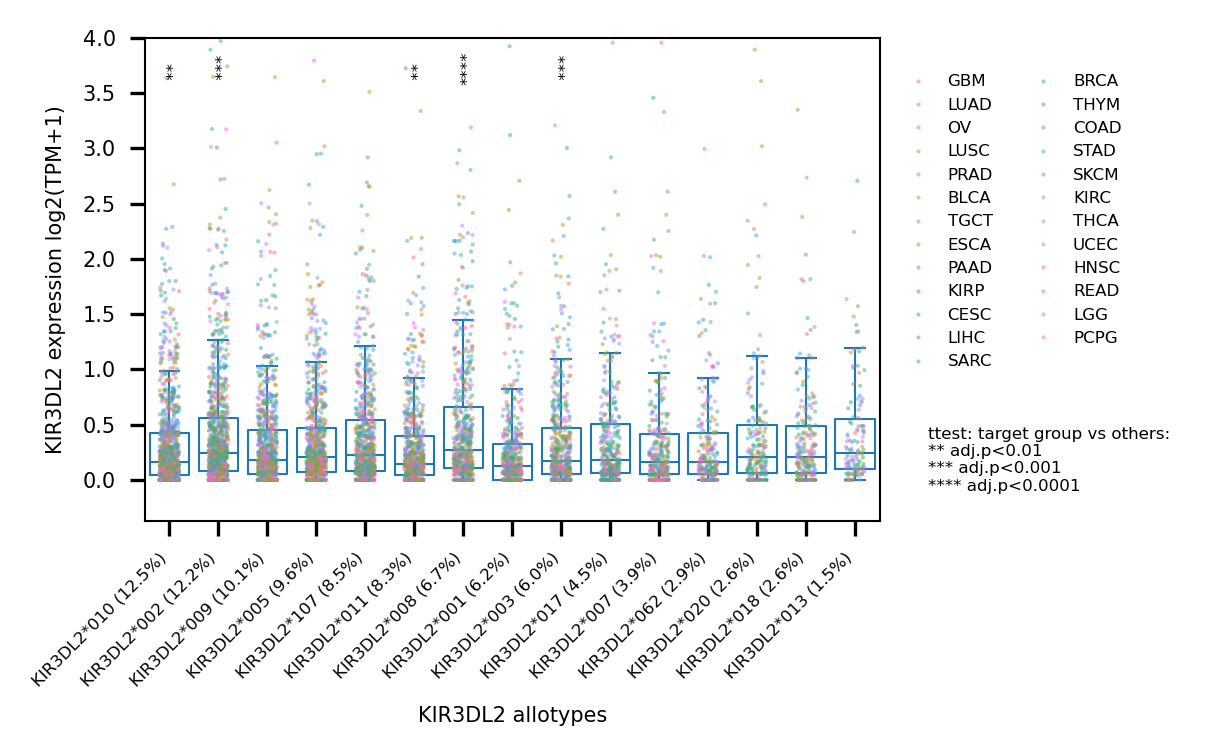

In [19]:
plt.figure(figsize=(4.,2.5))
ax = sns.boxplot(data=KIR3DL2_all_IGSF8,
                 x="allotypes",
                 order=frac["allotypes"][:15].values,
                 y="KIR3DL2",
                 fill=False,
                 linecolor="#137",
                 linewidth=.5,
                 showfliers=False
                 # hue=""
                )
ax = sns.stripplot(data=KIR3DL2_all_IGSF8,
                   x='allotypes',
                   order=frac["allotypes"][:15].values,
                   y='KIR3DL2',
                   s=1.,
                   alpha=.5,
                   jitter=.2, hue='project_id',
                  )

ax.set_xlabel("KIR3DL2 allotypes", fontsize=5)
ax.set_ylabel("KIR3DL2 expression log2(TPM+1)", fontsize=5)
ax.legend(loc=(1.02, .3), ncols=2, fontsize=4, frameon=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=4)

# p_value = f_oneway(*[KIR3DL2_all_IGSF8['IGSF8'][KIR3DL2_all_IGSF8['KIR3DL2 allotypes'] == b] for b in KIR3DL2_all_IGSF8['KIR3DL2 allotypes'].unique()])[1]
for idx,row in tstat_results.iterrows():
    ax.text(list(ordered_KIR_allotypes).index(idx)-.05, 3.6, oma.pl.pval2star(row["adj.pval"], keep_pval=False), fontsize=4, rotation=90)
ax.text(15.5, -.1, "ttest: target group vs others: \n** adj.p<0.01\n*** adj.p<0.001\n**** adj.p<0.0001", fontsize=4) #***p<0.001\\n****p<0.0001  \n*p<0.05\n
ax.set_ylim(None, 4)
plt.savefig("../figures/Reviewer3_point1_KIR3DL2_by_3DL2s.pdf",  bbox_inches = "tight")